In [1]:
%pylab inline
import pandas as pd
from pandas.api.types import is_categorical_dtype

from pyro.contrib.brm import defm, makedesc
from pyro.contrib.brm.design import metadata_from_df, metadata_from_cols, RealValued, Categorical, makedata
from pyro.contrib.brm.family import Normal, HalfCauchy, HalfNormal
from pyro.contrib.brm.formula import parse
from pyro.contrib.brm.model import model_repr
from pyro.contrib.brm.fit import fitted, Fit, get_scalar_param
from pyro.contrib.brm.priors import Prior
from pyro.contrib.brm.pyro_backend import backend as pyro_backend

from oed import *

Populating the interactive namespace from numpy and matplotlib


## Defining the model

Here we define the model and design space using existing brmp functionality. (We could of course provide a nicer interface.)

In [2]:
formula = parse('y ~ 1 + x1 + x2')

metadata = metadata_from_cols([
    RealValued('y'),
    Categorical('x1', ['a','b']),
    Categorical('x2', ['c','d']),
])

response = Normal
priors = [Prior(('b',), Normal(0.,1.)), Prior(('resp','sigma'), HalfNormal(.2))]

# Boiler plate.
model_desc = makedesc(formula, metadata, response, priors)

The design space for this model is:

In [3]:
metadata.levels(design_space_cols(formula, metadata))

[('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd')]

Build an empty data frame of the expected shape:

In [4]:
data_so_far = pd.DataFrame(dict(
    y=[],
    x1=pd.Categorical([]),
    x2=pd.Categorical([]),
))
assert len(data_so_far) == 0

## Computing the next design

Here we estimate the information gain for all designs. This current using a separate ANN for each design.

In [5]:
design, dstar, eigs, plot_data = next_trial(formula, model_desc, data_so_far, metadata)
(design, dstar, eigs)

Sampling from prior...
100 | -1.571015477180481
200 | -1.5627914667129517
300 | -1.5579378604888916
400 | -1.5547493696212769
500 | -1.5562996864318848
600 | -1.5489740371704102
700 | -1.5475032329559326
800 | -1.5476977825164795
900 | -1.540785551071167
1000 | -1.537623405456543
eig: -1.537934422492981
100 | -1.93192720413208
200 | -1.92518150806427
300 | -1.9243535995483398
400 | -1.9127285480499268
500 | -1.9107747077941895
600 | -1.9078593254089355
700 | -1.9084751605987549
800 | -1.9065815210342407
900 | -1.904369592666626
1000 | -1.9017289876937866
eig: -1.9023367166519165
100 | -1.9075771570205688
200 | -1.9016774892807007
300 | -1.8958911895751953
400 | -1.893024206161499
500 | -1.8893027305603027
600 | -1.8924429416656494
700 | -1.8851600885391235
800 | -1.8885363340377808
900 | -1.8818233013153076
1000 | -1.8797647953033447
eig: -1.8811531066894531
100 | -1.9554924964904785
200 | -1.9508135318756104
300 | -1.943943977355957
400 | -1.9384063482284546
500 | -1.9347082376480103


(('a', 'c'),
 0,
 [-1.537934422492981,
  -1.9023367166519165,
  -1.8811531066894531,
  -1.9221794605255127])

For each design/coefficient pair, this plot shows the target ($\theta \in [-0.5,0.5]$) and the function learned by the corresponing ANN. (It took a bit of fiddling with priors and `eps` before there was anything interesting for the ANN to learn.)

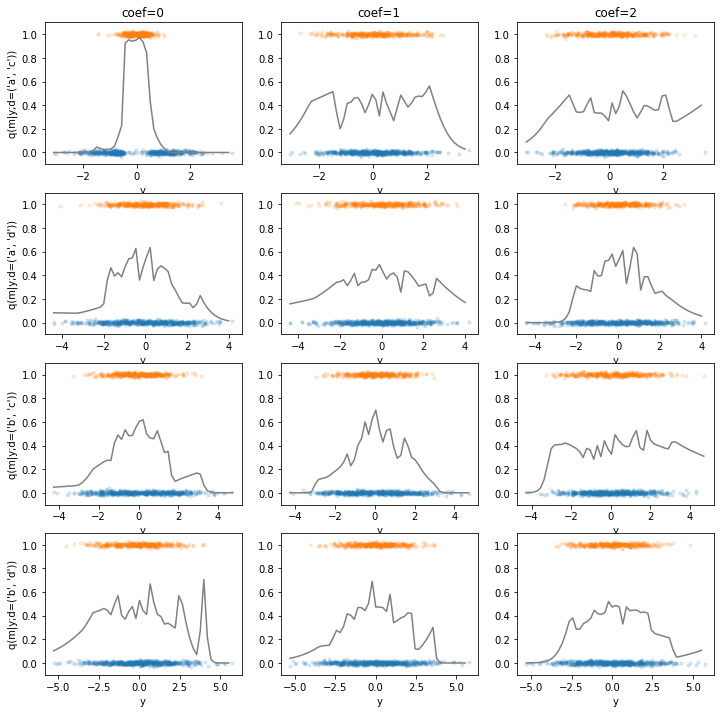

In [6]:
make_training_data_plot(plot_data)

We could now run the experiment, extend `data_so_far`, and get the next trial like so:

In [7]:
data_so_far2 = extend_df_with_result(formula, metadata, data_so_far, design, result=2.0)
data_so_far2

,y,x1,x2
0,2.0,a,c


In [8]:
_, _, _, plot_data2 = next_trial(formula, model_desc, data_so_far2, metadata)

warmup:   0%|          | 5/1500 [00:00<00:34, 43.20it/s, step size=1.21e-01, acc. prob=0.690]

Running HMC...


sample: 100%|██████████| 1500/1500 [00:33<00:00, 44.18it/s, step size=3.23e-01, acc. prob=0.818]


100 | -1.3062453269958496
200 | nan
300 | nan
400 | nan
500 | nan
600 | nan
700 | nan
800 | nan
900 | nan
1000 | nan
eig: nan
100 | -0.9746487140655518
200 | -0.9704810380935669
300 | -0.9662253856658936
400 | -0.9637476205825806
500 | -0.962245762348175
600 | -0.9610536694526672
700 | -0.9596891403198242
800 | -0.9585137367248535
900 | -0.9588947296142578
1000 | -0.9561977386474609
eig: -0.9561906456947327
100 | -0.9816743731498718
200 | -0.9753000736236572
300 | -0.9750423431396484
400 | nan
500 | nan
600 | nan
700 | nan
800 | nan
900 | nan
1000 | nan
eig: nan
100 | -1.2641795873641968
200 | -1.2611687183380127
300 | -1.2593942880630493
400 | -1.257102608680725
500 | -1.2542632818222046
600 | nan
700 | nan
800 | nan
900 | nan
1000 | nan
eig: nan


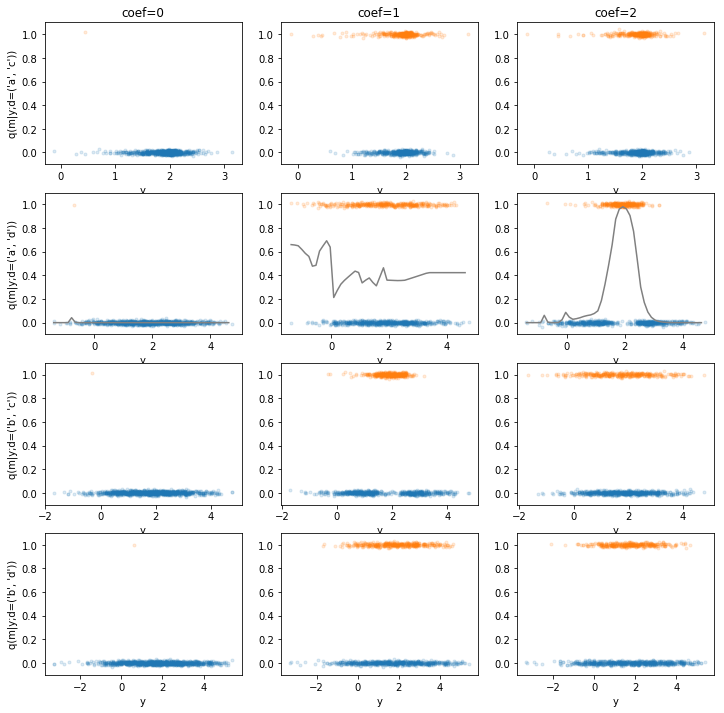

In [9]:
make_training_data_plot(plot_data2)